In [1]:
import json, csv, os, ast
from os import listdir
from os.path import isfile, join
import pandas as pd
import numpy as np
import scipy as sp
from IPython.display import display, HTML
import xml.etree.ElementTree
import seaborn as sns
import pylab as plt
from matplotlib.backends.backend_pdf import PdfPages

%matplotlib inline

sns.set_style('whitegrid')
plt.rcParams['figure.figsize']=(7,6)

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# S100
df_S100 = pd.read_csv('../../Task/BigTask/Parsed-results_S100.csv')
df_S6 = pd.read_csv('../../Task/BigTask/Parsed-results_S6.csv')

jitter = .2
alpha = .6
linewidth = .6
size = 10

In [3]:
# Funzione per Estrapolare il Dominio
def find_domain(url):
    st = url.split("/")
    s = st[2].split(".")
    return s[1]
def party_ln_replace(n):
    if (n == 1):
        return 'REP'
    if(n == 2):
        return 'DEM'
def get_party(doc_name):
    temp = doc_name.split('_')
    return temp[0]

def get_label(doc_name):
    temp = doc_name.split('_')
    return temp[1]

def compute_data(table, scale_rel):
    gold_dict = ['HIGH', 'LOW']
    table = table[['doc_id', 'party_ln', scale_rel, 'rel', 'off_page_count', 'time']]
    table = table[table["rel"].isin(gold_dict) == False]
    table = table.replace('LIE', 0).replace('FALSE', 1).replace('BARELYTRUE', 2).replace('HALFTRUE', 3).replace('MOSTLYTRUE', 4).replace('TRUE', 5)
    table['worker_party'] = table.apply(lambda row: party_ln_replace(row.party_ln), axis = 1)
    table['party_doc'] = table['doc_id']
    table['party_doc'] = table.apply(lambda row: get_party(row.party_doc), axis = 1)
    table['label'] = table.apply(lambda row: get_label(row.doc_id), axis = 1)
    dem_df = table.loc[table['worker_party'] == 'DEM']
    rep_df = table.loc[table['worker_party'] == 'REP']
    dem_df = dem_df[['label', 'time', 'off_page_count', 'rel', 'doc_id']]
    rep_df = rep_df[['label', 'time', 'off_page_count', 'rel', 'doc_id']]
   # print("-------------------------------------------------")
   # print("Dem on all")
   # print(round(dem_df["time"].mean(), 3))
   # print(round(dem_df["off_page_count"].mean(), 3))
   # print("\n")
    #print("Rep on all")
    #print(round(rep_df["time"].mean(), 3))
    #print(round(rep_df["off_page_count"].mean(), 3))
    #print("-------------------------------------------------")
    grouped_dem = dem_df.groupby(['label']).agg('mean')
    grouped_dem = grouped_dem.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])
    #display(grouped_dem.head(6))
    grouped_rep = rep_df.groupby(['label']).agg('mean')
    grouped_rep = grouped_rep.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])
    #display(grouped_rep.head(6))
    return grouped_dem, grouped_rep, table, dem_df, rep_df

In [4]:
grouped_dem_S100, grouped_rep_S100, df_S100, dem_df_S100, rep_df_S100 = compute_data(df_S100, 'S100_rel')
grouped_dem_S6, grouped_rep_S6, df_S6, dem_df_S6, rep_df_S6 = compute_data(df_S6, 'S6_rel')

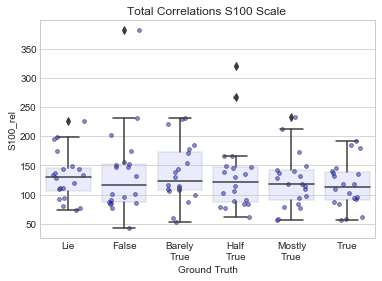

In [17]:
 gold_dict = ['HIGH', 'LOW']

mergedS100 = dem_df_S100[['doc_id', "time", 'rel']].groupby(['doc_id']).agg('mean').reset_index()
mergedS6 = rep_df_S100[['doc_id', "time", 'rel']].groupby(['doc_id']).agg('mean').reset_index()

m = {"s": 15, "alpha": alpha, 'linewidths': linewidth, "facecolor": '#343deb','edgecolor': 'black'}
m2 = {"s": 15, "alpha": alpha, 'linewidths': linewidth, "facecolor": '#eb3434','edgecolor': 'black'}
#plt.figure(figsize=(9, 6))
ax = sns.regplot(x = 'rel', y = 'time', data = mergedS100, fit_reg = False, 
                 x_jitter = .28, scatter_kws = m)
sns.boxplot( x = 'rel', y = "time", data = mergedS100, 
            boxprops = dict(facecolor = '#343deb', alpha=0.1, zorder = 0))
ax.set_title("Total Correlations S100 Scale ")
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
#ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set(ylabel = 'S100_rel', xlabel = 'Ground Truth')
sns.despine (top=False,right=False,left=False,bottom=False)

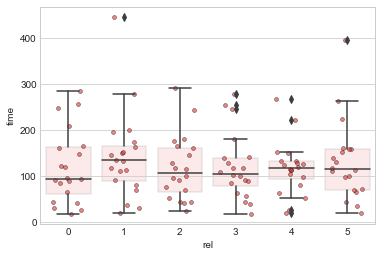

In [15]:
ax.set_title("Total Correlations S100 Scale ")
ax.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax.set_yticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax1 = sns.regplot(x = 'rel', y = 'time', data = mergedS6, fit_reg = False, 
                 x_jitter = .28, scatter_kws = m2)
sns.boxplot( x = 'rel', y = "time", data = mergedS6, 
            boxprops = dict(facecolor = '#eb3434', alpha=0.1, zorder = 0))
ax.set(ylabel = 'S100_rel', xlabel = 'Ground Truth')
sns.despine (top=False,right=False,left=False,bottom=False)

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)

ax1 = sns.barplot(x = grouped_dem_S6.index, y = 'time', data = grouped_dem_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][0])
ax2 = sns.barplot(x = grouped_dem_S100.index, y = 'time', data = grouped_dem_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][1])
ax3 = sns.barplot(x = grouped_rep_S6.index, y = 'time', data = grouped_rep_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][0])
ax4 = sns.barplot(x = grouped_rep_S100.index, y = 'time', data = grouped_rep_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][1])

ax1.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax1.set(title = "S6 Scale", ylabel = 'Democrats Time', xlabel = '')
ax1.set_yticks(np.arange(0, 175, step = 50))
ax2.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax2.set(title = "S100 Scale", ylabel = '', xlabel = '')
ax2.set_yticks(np.arange(0, 175, step = 50))
ax3.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax3.set(ylabel = 'Republicans Time', xlabel = 'Labels')
ax3.set_yticks(np.arange(0, 175, step = 50))
ax4.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax4.set(ylabel = '', xlabel = 'Labels')
ax4.set_yticks(np.arange(0, 175, step = 50))
fig.suptitle("Party vs All Statements\nMean Time per Statement")

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
ax1 = sns.barplot(x = grouped_dem_S6.index, y = 'off_page_count', data = grouped_dem_S6, palette = sns.dark_palette("muted purple", input="xkcd"),  ax=axs[0][0])
ax2 = sns.barplot(x = grouped_dem_S100.index, y = 'off_page_count', data = grouped_dem_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax=axs[0][1])
ax3 = sns.barplot(x = grouped_rep_S6.index, y = 'off_page_count', data = grouped_rep_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax=axs[1][0])
ax4 = sns.barplot(x = grouped_rep_S100.index, y = 'off_page_count', data = grouped_rep_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax=axs[1][1])
ax1.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax1.set(title = "S6 Scale", ylabel = 'Democrats\nOff Page Count', xlabel = '')
ax1.set_yticks(np.arange(0, 3, step = .5))
ax2.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax2.set(title = "S100 Scale", ylabel = '', xlabel = '')
ax2.set_yticks(np.arange(0, 3, step = .5))
ax3.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax3.set(ylabel = 'Republicans\nOff Page Count', xlabel = 'Labels')
ax3.set_yticks(np.arange(0, 3, step = .5))
ax4.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax4.set(ylabel = '', xlabel = 'Labels')
ax4.set_yticks(np.arange(0, 3, step = .5))
fig.suptitle("Party vs All Statements\nMean Off Page Count per Statement")

In [ ]:
# DEM SU DEM | DEM SU REP | REP SU REP | REP SU DEM
dem_dem_df_S100 = df_S100.loc[(df_S100['worker_party'] == 'DEM') & (df_S100['party_doc'] == 'DEM')]
dem_rep_df_S100 = df_S100.loc[(df_S100['worker_party'] == 'DEM') & (df_S100['party_doc'] == 'REP')]
rep_rep_df_S100 = df_S100.loc[(df_S100['worker_party'] == 'REP') & (df_S100['party_doc'] == 'REP')]
rep_dem_df_S100 = df_S100.loc[(df_S100['worker_party'] == 'REP') & (df_S100['party_doc'] == 'DEM')]

dem_dem_df_S100 = dem_dem_df_S100[['label', 'time', 'off_page_count']]
dem_rep_df_S100 = dem_rep_df_S100[['label', 'time', 'off_page_count']]
rep_rep_df_S100 = rep_rep_df_S100[['label', 'time', 'off_page_count']]
rep_dem_df_S100 = rep_dem_df_S100[['label', 'time', 'off_page_count']]

dem_dem_df_S6 = df_S6.loc[(df_S6['worker_party'] == 'DEM') & (df_S6['party_doc'] == 'DEM')]
dem_rep_df_S6 = df_S6.loc[(df_S6['worker_party'] == 'DEM') & (df_S6['party_doc'] == 'REP')]
rep_rep_df_S6 = df_S6.loc[(df_S6['worker_party'] == 'REP') & (df_S6['party_doc'] == 'REP')]
rep_dem_df_S6 = df_S6.loc[(df_S6['worker_party'] == 'REP') & (df_S6['party_doc'] == 'DEM')]

dem_dem_df_S6 = dem_dem_df_S6[['label', 'time', 'off_page_count']]
dem_rep_df_S6 = dem_rep_df_S6[['label', 'time', 'off_page_count']]
rep_rep_df_S6 = rep_rep_df_S6[['label', 'time', 'off_page_count']]
rep_dem_df_S6 = rep_dem_df_S6[['label', 'time', 'off_page_count']]

In [ ]:
grouped_dem_dem_S100 = dem_dem_df_S100.groupby(['label']).agg('mean')
grouped_dem_dem_S100 = grouped_dem_dem_S100.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])
grouped_dem_dem_S6 = dem_dem_df_S6.groupby(['label']).agg('mean')
grouped_dem_dem_S6 = grouped_dem_dem_S6.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])

grouped_dem_rep_S100 = dem_rep_df_S100.groupby(['label']).agg('mean')
grouped_dem_rep_S100 = grouped_dem_rep_S100.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])
grouped_dem_rep_S6 = dem_rep_df_S6.groupby(['label']).agg('mean')
grouped_dem_rep_S6 = grouped_dem_rep_S6.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])

fig, axs = plt.subplots(nrows = 2, ncols = 2)
ax1 = sns.barplot(x = grouped_dem_dem_S6.index, y = 'time', data = grouped_dem_dem_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][0])
ax2 = sns.barplot(x = grouped_dem_dem_S100.index, y = 'time', data = grouped_dem_dem_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][1])
ax3 = sns.barplot(x = grouped_dem_rep_S6.index, y = 'time', data = grouped_dem_rep_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][0])
ax4 = sns.barplot(x = grouped_dem_rep_S100.index, y = 'time', data = grouped_dem_rep_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][1])

ax1.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax1.set(title = "S6 Scale", ylabel = 'Democrats vs Democrats\nTime', xlabel = '')
ax1.set_yticks(np.arange(0, 175, step = 50))
ax2.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax2.set(title = "S100 Scale", ylabel = '', xlabel = '')
ax2.set_yticks(np.arange(0, 175, step = 50))
ax3.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax3.set(ylabel = 'Democrats vs Republicans\nTime', xlabel = 'Labels')
ax3.set_yticks(np.arange(0, 175, step = 50))
ax4.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax4.set(ylabel = '', xlabel = 'Labels')
ax4.set_yticks(np.arange(0, 175, step = 50))
fig.suptitle("Democrat vs Democrat on top\nDemocrat vs Republican on bottom\nMean Time per Statement")

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2)
ax1 = sns.barplot(x = grouped_dem_dem_S6.index, y = 'off_page_count', data = grouped_dem_dem_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][0])
ax2 = sns.barplot(x = grouped_dem_dem_S100.index, y = 'off_page_count', data = grouped_dem_dem_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][1])
ax3 = sns.barplot(x = grouped_dem_rep_S6.index, y = 'off_page_count', data = grouped_dem_rep_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][0])
ax4 = sns.barplot(x = grouped_dem_rep_S100.index, y = 'off_page_count', data = grouped_dem_rep_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][1])

ax1.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax1.set(title = "S6 Scale", ylabel = 'Democrats vs Democrats\nOff Page Count', xlabel = '')
ax1.set_yticks(np.arange(0, 3, step = .5))
ax2.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax2.set(title = "S100 Scale", ylabel = '', xlabel = '')
ax2.set_yticks(np.arange(0, 3, step = .5))
ax3.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax3.set(ylabel = 'Democrats vs Republicans\nOff Page Count', xlabel = 'Labels')
ax3.set_yticks(np.arange(0, 3, step = .5))
ax4.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax4.set(ylabel = '', xlabel = 'Labels')
ax4.set_yticks(np.arange(0, 3, step = .5))
fig.suptitle("Democrat vs Democrat on top\nDemocrat vs Republican on bottom\nMean Off Page Count per Statement")

In [ ]:
grouped_rep_rep_S100 = rep_rep_df_S100.groupby(['label']).agg('mean')
grouped_rep_rep_S100 = grouped_rep_rep_S100.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])
grouped_rep_rep_S6 = rep_rep_df_S6.groupby(['label']).agg('mean')
grouped_rep_rep_S6 = grouped_rep_rep_S6.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])

grouped_rep_dem_S100 = rep_dem_df_S100.groupby(['label']).agg('mean')
grouped_rep_dem_S100 = grouped_rep_dem_S100.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])
grouped_rep_dem_S6 = rep_dem_df_S6.groupby(['label']).agg('mean')
grouped_rep_dem_S6 = grouped_rep_dem_S6.reindex(["LIE", "FALSE", "BARELYTRUE", "HALFTRUE", "MOSTLYTRUE", "TRUE"])

fig, axs = plt.subplots(nrows = 2, ncols = 2)
ax1 = sns.barplot(x = grouped_rep_rep_S6.index, y = 'time', data = grouped_rep_rep_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][0])
ax2 = sns.barplot(x = grouped_rep_rep_S100.index, y = 'time', data = grouped_rep_rep_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[0][1])
ax3 = sns.barplot(x = grouped_rep_dem_S6.index, y = 'time', data = grouped_rep_dem_S6, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][0])
ax4 = sns.barplot(x = grouped_rep_dem_S100.index, y = 'time', data = grouped_rep_dem_S100, palette = sns.dark_palette("muted purple", input="xkcd"), ax = axs[1][1])

ax1.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax1.set(title = "S6 Scale", ylabel = 'Republicans vs Republicans\nTime', xlabel = '')
ax1.set_yticks(np.arange(0, 175, step = 50))
ax2.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax2.set(title = "S100 Scale", ylabel = '', xlabel = '')
ax2.set_yticks(np.arange(0, 175, step = 50))
ax3.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax3.set(ylabel = 'Republicans vs Democrats\nTime', xlabel = 'Labels')
ax3.set_yticks(np.arange(0, 175, step = 50))
ax4.set_xticklabels(['Lie', 'False', 'Barely\nTrue', 'Half\nTrue', 'Mostly\nTrue', 'True'])
ax4.set(ylabel = '', xlabel = 'Labels')
ax4.set_yticks(np.arange(0, 175, step = 50))
fig.suptitle("Republicans vs Republicans on top\nRepublicans vs Democrats on bottom\nMean Time per Statement")

In [ ]:
print("-------------------------------------------------")
print("Dem on Dem")
print(round(dem_dem_df["time"].mean(), 3))
print(round(dem_dem_df["off_page_count"].mean(), 3))
print("\n")
print("Dem on Rep")
print(round(dem_rep_df["time"].mean(), 3))
print(round(dem_rep_df["off_page_count"].mean(), 3))
print("-------------------------------------------------")
print("\n")
print("Rep on Rep")
print(round(rep_rep_df["time"].mean(), 3))
print(round(rep_rep_df["off_page_count"].mean(), 3))
print("\n")
print("Rep on Dem")
print(round(rep_dem_df["time"].mean(), 3))
print(round(rep_dem_df["off_page_count"].mean(), 3))
print("-------------------------------------------------")
grouped_dem_dem = dem_dem_df.groupby(['label']).agg('mean')
display(grouped_dem_dem.head(6))

grouped_dem_rep = dem_rep_df.groupby(['label']).agg('mean')
display(grouped_dem_rep.head(6))

grouped_rep_rep = rep_rep_df.groupby(['label']).agg('mean')
display(grouped_rep_rep.head(6))

grouped_rep_dem = rep_dem_df.groupby(['label']).agg('mean')
display(grouped_rep_dem.head(6))

In [ ]:
my_df = df
display(my_df.shape[0])
my_df['url'][80] = "http://www.fakeURL.com"
my_df['url'][373] = "http://www.fakeURL.com"
# Prendo i domini
my_df['url'] = my_df.apply(lambda row: find_domain(row.url), axis = 1)

poli_df = my_df[my_df['url'] == 'politifact']
print("Numero di polifact: {}". format(poli_df.shape[0]))
print("Numero Totale: {}". format(my_df.shape[0]))
ratio = poli_df.shape[0] / my_df.shape[0]
print("{} / {} = {}".format(poli_df.shape[0], my_df.shape[0], ratio))

In [ ]:
# Numero volte polifact, S6 e label coincide
my_df = df_s6
# Prendo i domini
my_df['url'] = my_df.apply(lambda row: find_domain(row.url), axis = 1)
poli_df = my_df[my_df['url'] == 'politifact']

print("Numero di polifact: {}". format(poli_df.shape[0]))
print("Numero Totale: {}". format(my_df.shape[0]))
ratio = poli_df.shape[0] / my_df.shape[0]
print("{} / {} = {}".format(poli_df.shape[0], my_df.shape[0], ratio))